In [ ]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn #파이토치 nn모듈은 신경망 아키텍처를 만들 수 있는 빌딩 블럭이 들어가 있고 모듈은 하나 이상의 서브 모듈을 속성으로 가지며 파라미터 추정이 가능하다.

t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) 
t_u = torch.tensor(t_u).unsqueeze(1) 

t_u.shape

torch.Size([11, 1])

In [ ]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

# 6.2

In [ ]:
#nn.Module의 모든 서브클래스에는 __call__메소드가 정의되어있어 forward대신 사용할 수 있다.

linear_model = nn.Linear(1, 1) # <1>
linear_model(t_un_val) #linear_model.forwaud(t_un_val)이런식의 사용은 하지말자.

tensor([[-1.0210],
        [-1.2894]], grad_fn=<AddmmBackward0>)

In [ ]:
linear_model.weight

Parameter containing:
tensor([[-0.2033]], requires_grad=True)

In [ ]:
linear_model.bias

Parameter containing:
tensor([-0.2950], requires_grad=True)

In [ ]:
#배치 입력만들기: 배치의 크기가 10이고 입력피처의 크기가 1이라면
x=torch.ones(10,1)
linear_model(x) #선형함수를 통해 나온 결과값, shape: 배치크기x입력피쳐크기

tensor([[-0.4984],
        [-0.4984],
        [-0.4984],
        [-0.4984],
        [-0.4984],
        [-0.4984],
        [-0.4984],
        [-0.4984],
        [-0.4984],
        [-0.4984]], grad_fn=<AddmmBackward0>)

In [ ]:
#배치 최적화
linear_model = nn.Linear(1, 1) 
optimizer = optim.SGD(
    linear_model.parameters(), #[params]대신 넣은것
    lr=1e-2)
linear_model.parameters() #이제 nn.Module이나 어떤 하위 모듈에 대해서도 parameters메소드만 있으면 파라미터 리스트 얻을 수 있다.

Parameter containing:
tensor([[0.8989]], requires_grad=True)

In [ ]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[0.8989]], requires_grad=True), Parameter containing:
 tensor([0.4982], requires_grad=True)]

In [ ]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val,
                  t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train) # <1>
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val) # <1>
        loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        loss_train.backward() # <2>
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")

In [ ]:
#torch.nn은 손실함수 또한 가지고 있다.
training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    model = linear_model,
    loss_fn = nn.MSELoss(), #이제 직접만드는 손실 함수를 사용하지 않는다.
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 99.1553, Validation loss 9.9676
Epoch 1000, Training loss 4.0167, Validation loss 6.2427
Epoch 2000, Training loss 3.1984, Validation loss 3.0092
Epoch 3000, Training loss 3.1718, Validation loss 2.5531

Parameter containing:
tensor([[5.2340]], requires_grad=True)
Parameter containing:
tensor([-16.3197], requires_grad=True)


# 6.3

In [ ]:
#nn은 nn.Sequential 컨테이너를 통해 모듈을 간단하게 결합시켜준다.
seq_model = nn.Sequential(
            nn.Linear(1, 13), 
            nn.Tanh(),
            nn.Linear(13, 1)) #앞의 13과 일치해야한다.  차원을 맞춰줘야함
seq_model #이 모델은 한개의 입력피처로부터 13개의 은닉된 피처로 펼쳐지며 결과값을 tanh인 활성함수로 넘겨 결과로 나온 13개의 숫자를 선형결합을 통해 하나의 출력 피처로 변형한다.

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [ ]:
#파라미터 차원정보
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

In [ ]:
#named_parameters메소드를 통해 파라미터를 이름으로 식별가능하게 하면 매우 편리하다.
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


In [ ]:
#처음 모델을 만들때부터 파라미터의 이름을 지정하는것도 가능하다.

from collections import OrderedDict

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, 8)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(8, 1))
]))

seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [ ]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


In [ ]:
#이름으로 접근해 특정 파라미터값 확인가능
print(seq_model.output_linear.weight)
print()
print(seq_model.output_linear.bias)

Parameter containing:
tensor([[ 0.0114, -0.0697, -0.1227,  0.1033,  0.1502,  0.2530,  0.1065,  0.2980]],
       requires_grad=True)

Parameter containing:
tensor([-0.3254], requires_grad=True)


In [ ]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)
    
print('output', seq_model(t_un_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

Epoch 1, Training loss 238.4284, Validation loss 38.6290
Epoch 1000, Training loss 6.4116, Validation loss 2.0531
Epoch 2000, Training loss 4.9407, Validation loss 0.8552
Epoch 3000, Training loss 2.5163, Validation loss 1.3511
Epoch 4000, Training loss 1.9525, Validation loss 1.7720
Epoch 5000, Training loss 1.8613, Validation loss 2.1267
output tensor([[2.5624],
        [7.9818]], grad_fn=<AddmmBackward0>)
answer tensor([[0.5000],
        [8.0000]])
hidden tensor([[ 0.0084],
        [ 0.0367],
        [ 0.0161],
        [-0.0283],
        [ 0.0341],
        [-0.0108],
        [ 0.0011],
        [-0.0120]])


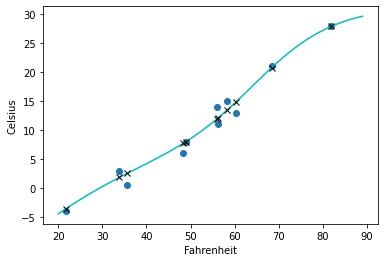

In [ ]:
#선형모델과 비교해 더 유연한 모델을 얻을 수 있다.
from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')